Name: 
1) Somnath Paul     2022BIFT07AED023
2) Aashish Kumar    2022BIFT07AED012
3) Subham Dwivedi   2022BCSE07AED717

Developing an AI image classifier based application.

In this project, we'll train an image classifier to recognize different animals. You can imagine using something like this in a phone app that tells you the name of the animals your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using this dataset of 320 animal images. Some of the examples are: 

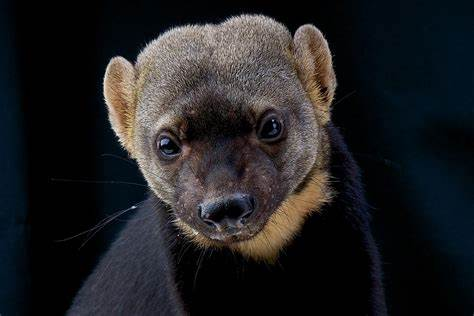 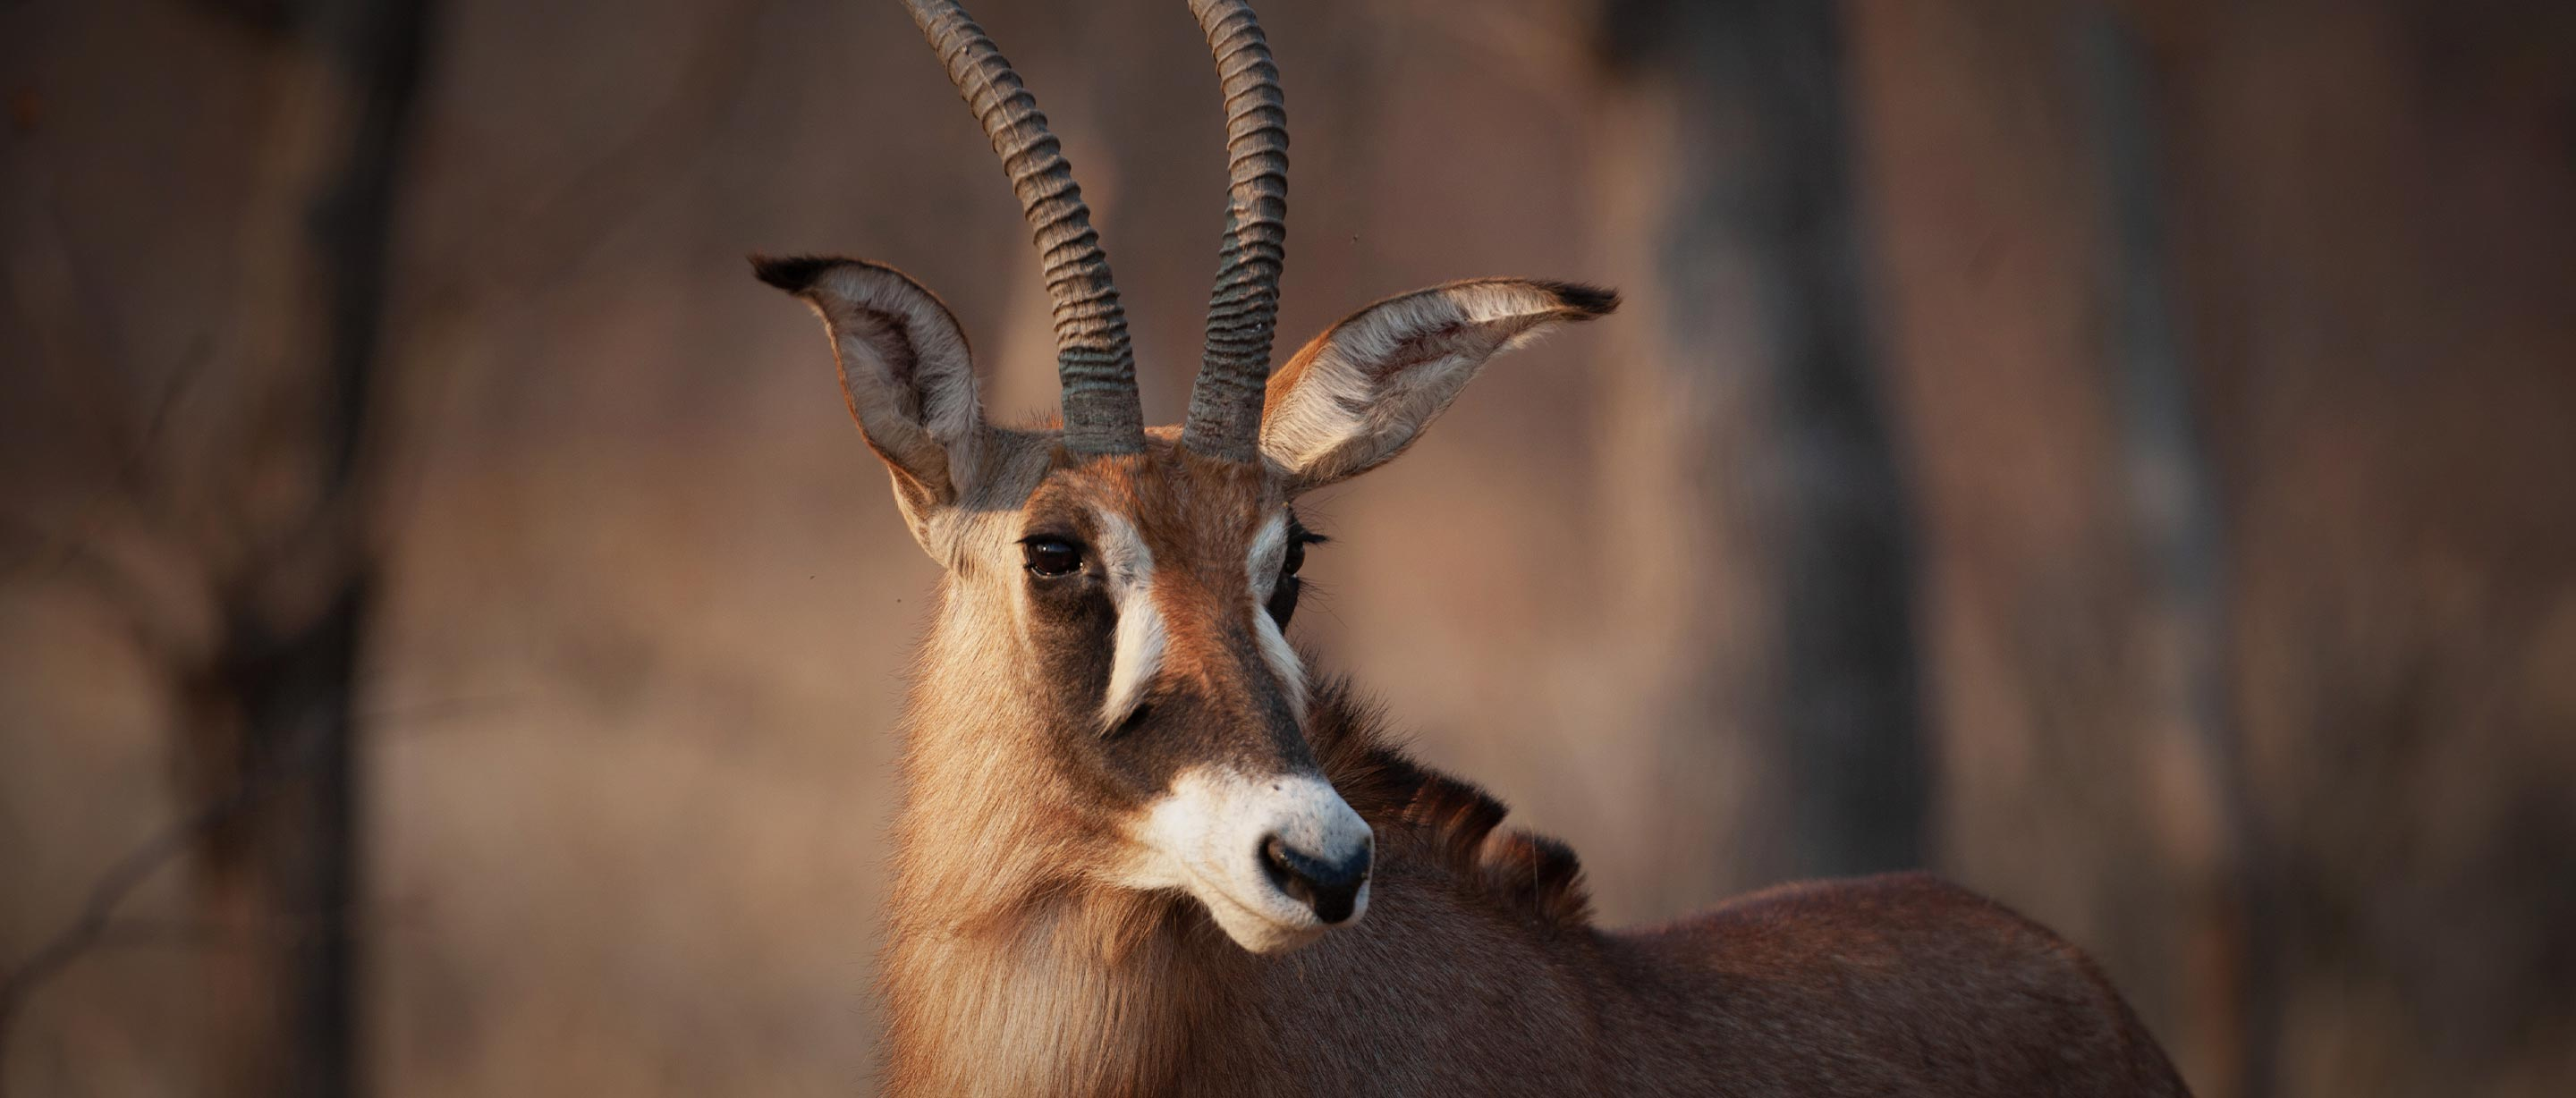 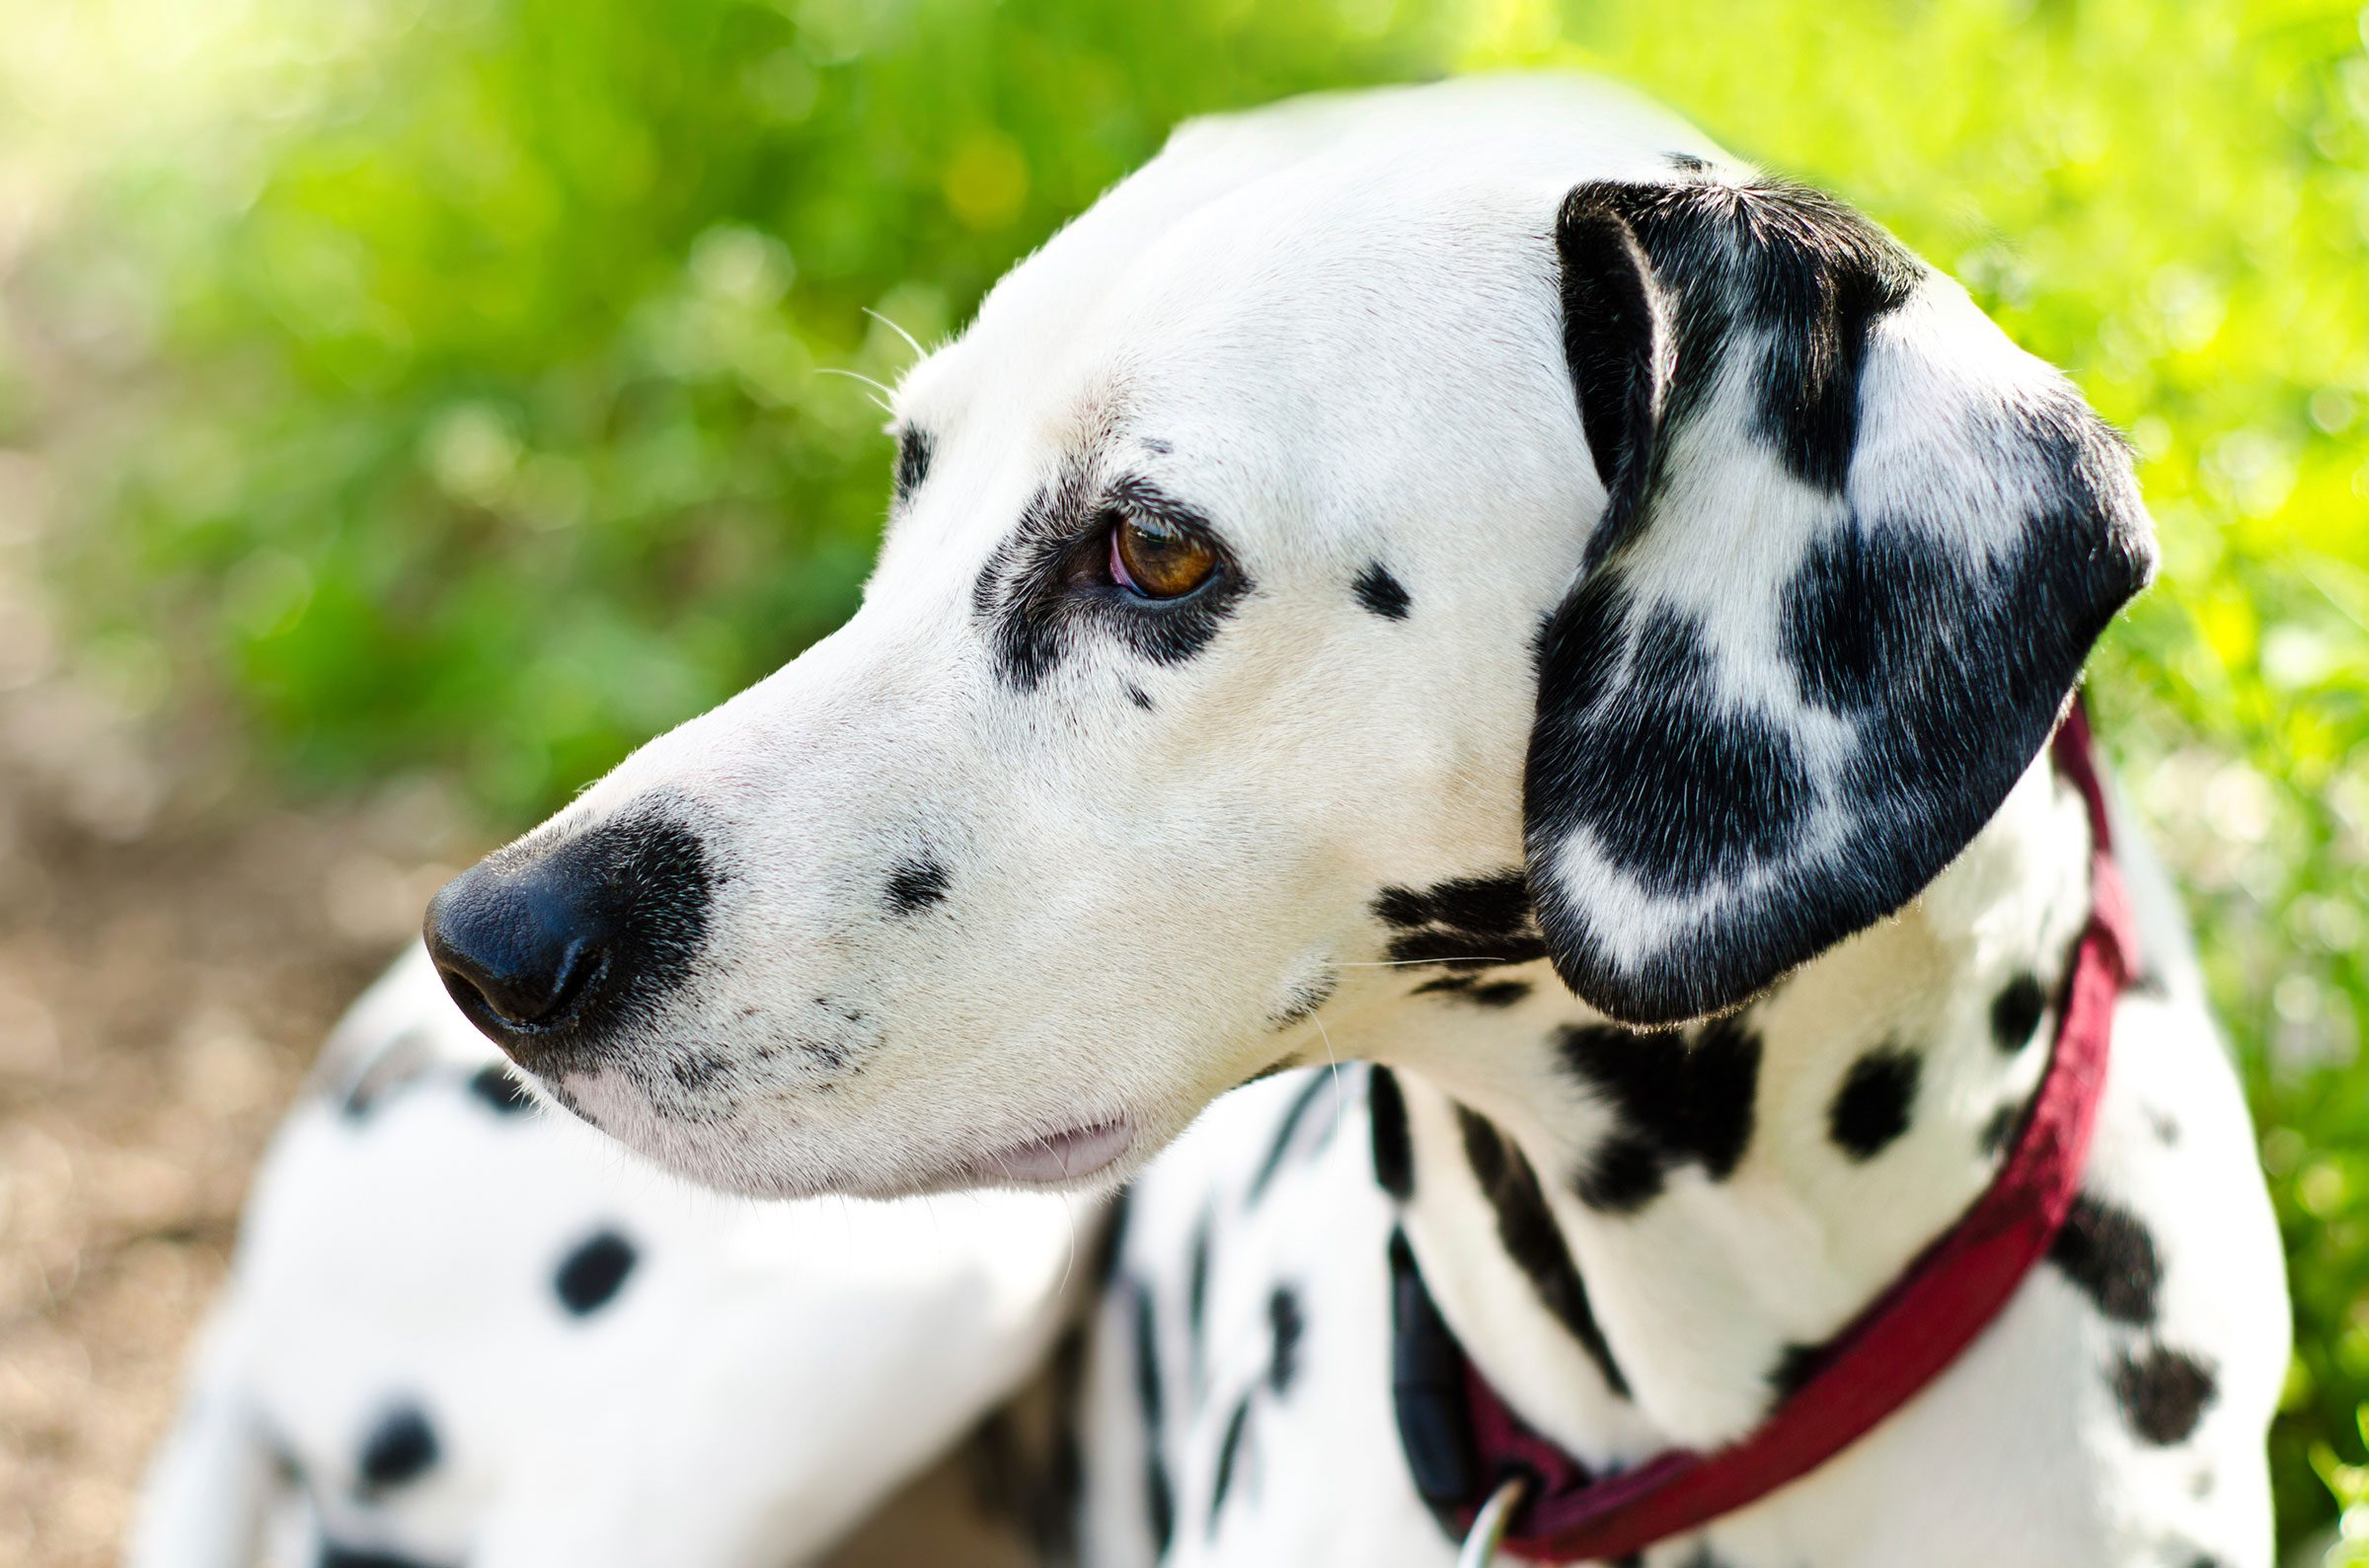 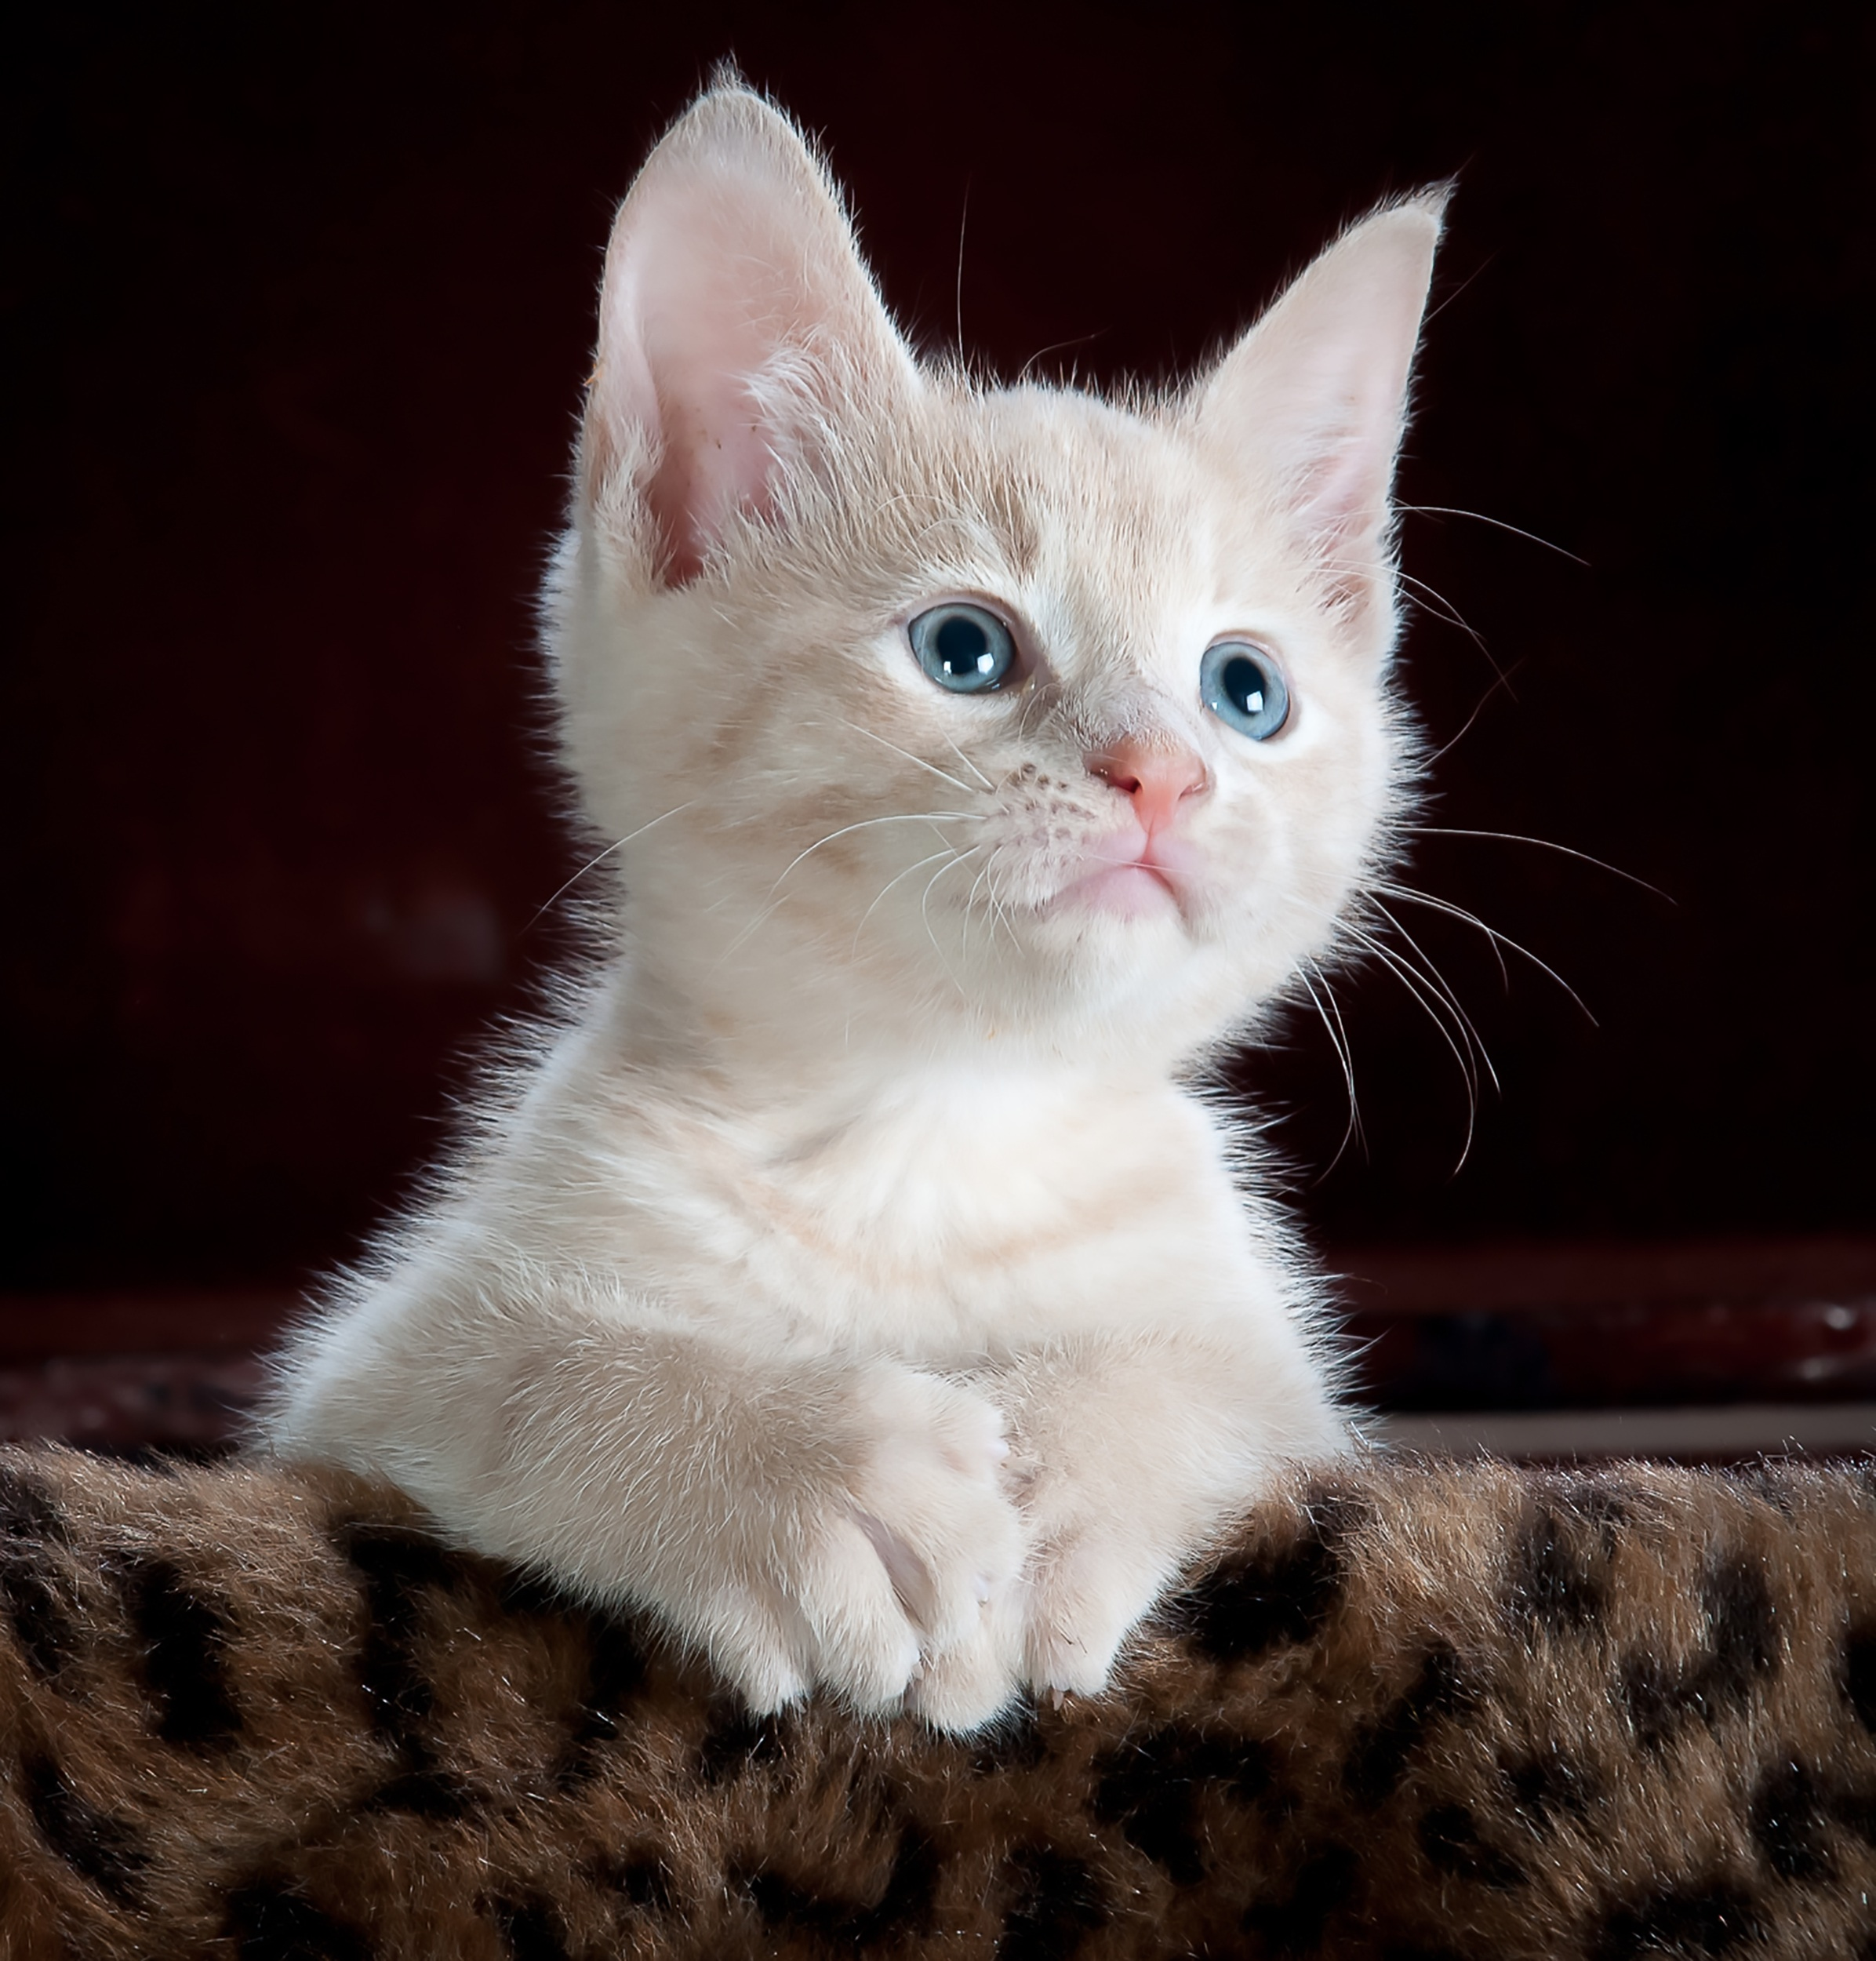

The project is broken down into multiple steps:

1)   Load and preprocess the image dataset
2)   Train the image classifier on your dataset
3)   Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it.

First up is importing the packages and Define Auxiliary Functions you'll need. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [3]:
#!conda install -c pytorch torchvision
#!pip install skillsnetwork tqdm
#!pip install  skillsnetwork
import os
import uuid
import shutil
import json
from botocore.client import Config
import ibm_boto3
import copy
from datetime import datetime
from skillsnetwork import cvstudio 
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from matplotlib.pyplot import imshow
from tqdm import tqdm
from ipywidgets import IntProgress
import time 
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader,random_split
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)
def plot_stuff(COST,ACC):    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color = color)
    ax1.set_xlabel('Iteration', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color = color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()
def imshow_(inp, title=None):
    """Imshow for Tensor."""
    inp = inp .permute(1, 2, 0).numpy() 
    print(inp.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  
    plt.show()
def result(model,x,y):
    #x,y=sample
    z=model(x.unsqueeze_(0))
    _,yhat=torch.max(z.data, 1)
    
    if yhat.item()!=y:
        text="predicted: {} actual: {}".format(str(yhat.item()),y)
        print(text)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device type is", device)


the device type is cpu


Load Data:


100%|██████████| 320/320 [01:26<00:00,  3.69it/s]


defult transform for pretrained model resnet18
this is the training set
defult transform for pretrained model resnet18
this is the test set
(224, 224, 3)


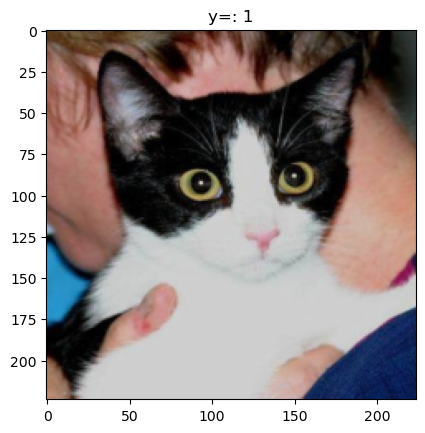

(224, 224, 3)


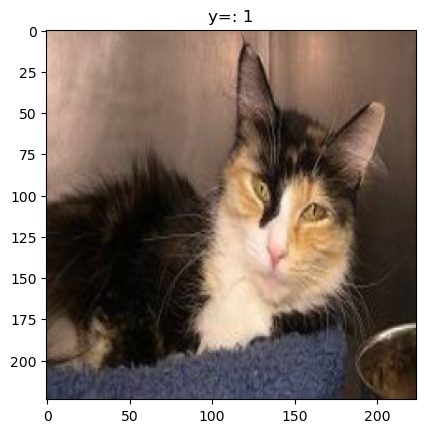

(224, 224, 3)


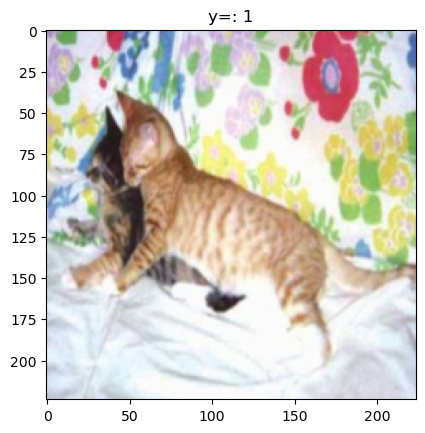

In [5]:
# Get the Dataset
# Initialize the CV Studio Client
cvstudioClient = cvstudio.CVStudio()
# # Download All Images
cvstudioClient.downloadAll()
percentage_train=0.9
train_set=cvstudioClient.getDataset(train_test='train',percentage_train=percentage_train)
val_set=cvstudioClient.getDataset(train_test='test',percentage_train=percentage_train)
i=0

for x,y  in val_set:
    imshow_(x,"y=: {}".format(str(y.item())))
    i+=1
    if i==3:
        break
n_epochs=10
batch_size=32
lr=0.000001
momentum=0.9
lr_scheduler=True
base_lr=0.001
max_lr=0.01

Load Model and Train:

In [6]:
def train_model(model, train_loader,validation_loader, criterion, optimizer, n_epochs,print_=True):
    loss_list = []
    accuracy_list = []
    correct = 0
    #global:val_set
    n_test = len(val_set)
    accuracy_best=0
    best_model_wts = copy.deepcopy(model.state_dict())

    # Loop through epochs
        # Loop through the data in loader
    print("The first epoch should take several minutes")
    for epoch in tqdm(range(n_epochs)):
        
        loss_sublist = []
        # Loop through the data in loader

        for x, y in train_loader:
            x, y=x.to(device), y.to(device)
            model.train() 

            z = model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.data.item())
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()
        print("epoch {} done".format(epoch) )

        scheduler.step()    
        loss_list.append(np.mean(loss_sublist))
        correct = 0


        for x_test, y_test in validation_loader:
            x_test, y_test=x_test.to(device), y_test.to(device)
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / n_test
        accuracy_list.append(accuracy)
        if accuracy>accuracy_best:
            accuracy_best=accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        
        
        if print_:
            print('learning rate',optimizer.param_groups[0]['lr'])
            print("The validaion  Cost for each epoch " + str(epoch + 1) + ": " + str(np.mean(loss_sublist)))
            print("The validation accuracy for epoch " + str(epoch + 1) + ": " + str(accuracy)) 
    model.load_state_dict(best_model_wts)    
    return accuracy_list,loss_list, model

Load the pre-trained model resnet18. Set the parameter pretrained to true.:

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jupyterlab/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?it/s]

The first epoch should take several minutes
epoch 0 done


 10%|█         | 1/10 [00:44<06:41, 44.60s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 1: 1.4259256919225056
The validation accuracy for epoch 1: 0.5625
epoch 1 done


 20%|██        | 2/10 [01:23<05:27, 40.99s/it]

learning rate 0.0046
The validaion  Cost for each epoch 2: 0.6415354775057899
The validation accuracy for epoch 2: 0.875
epoch 2 done


 30%|███       | 3/10 [02:03<04:46, 40.96s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 3: 0.21255756666262945
The validation accuracy for epoch 3: 0.90625
epoch 3 done


 40%|████      | 4/10 [02:43<04:02, 40.38s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 4: 0.13208674101365936
The validation accuracy for epoch 4: 0.90625
epoch 4 done


 50%|█████     | 5/10 [03:22<03:19, 39.85s/it]

learning rate 0.010000000000000002
The validaion  Cost for each epoch 5: 0.11866789725091723
The validation accuracy for epoch 5: 0.90625
epoch 5 done


 60%|██████    | 6/10 [04:06<02:45, 41.32s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 6: 0.06636784142918056
The validation accuracy for epoch 6: 0.90625
epoch 6 done


 70%|███████   | 7/10 [04:50<02:06, 42.32s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 7: 0.060705922130081386
The validation accuracy for epoch 7: 0.90625
epoch 7 done


 80%|████████  | 8/10 [05:37<01:27, 43.75s/it]

learning rate 0.0046
The validaion  Cost for each epoch 8: 0.07007739755014579
The validation accuracy for epoch 8: 0.90625
epoch 8 done


 90%|█████████ | 9/10 [06:21<00:43, 43.63s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 9: 0.052760517224669456
The validation accuracy for epoch 9: 0.90625
epoch 9 done


100%|██████████| 10/10 [07:03<00:00, 42.31s/it]

learning rate 0.001
The validaion  Cost for each epoch 10: 0.05305210190514723
The validation accuracy for epoch 10: 0.90625
elapsed time 423.3753921985626


Congratulations your results have been reported back to CV Studio!
File Uploaded


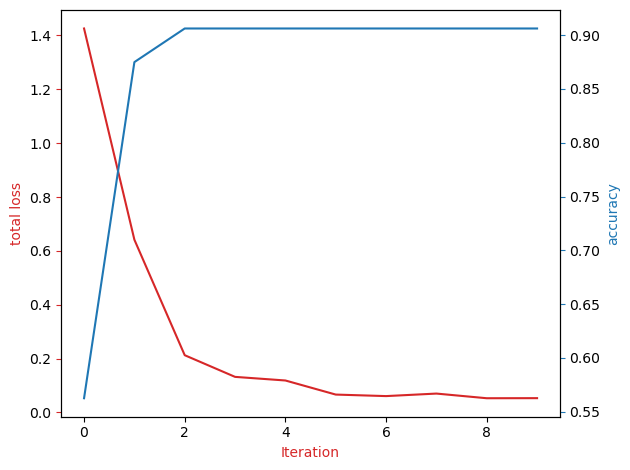

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
        param.requires_grad = False
n_classes=train_set.n_classes
n_classes
# Type your code here
model.fc = nn.Linear(512, n_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(dataset=train_set , batch_size=batch_size,shuffle=True)
validation_loader= torch.utils.data.DataLoader(dataset=val_set , batch_size=1)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
if lr_scheduler:
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01,step_size_up=5,mode="triangular2")
start_datetime = datetime.now()
start_time=time.time()

accuracy_list,loss_list, model=train_model(model,train_loader , validation_loader, criterion, optimizer, n_epochs=n_epochs)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("elapsed time", elapsed_time )

# Now run the following to report back the results of the training run to CV Studio:

parameters = {
    'epochs': n_epochs,
    'learningRate': lr,
    'momentum':momentum,
    'percentage used training':percentage_train,
    "learningRatescheduler": {"lr_scheduler":lr_scheduler,"base_lr":base_lr, "max_lr" :max_lr}
    
    
}
result = cvstudioClient.report(started=start_datetime, completed=end_datetime, parameters=parameters, accuracy={ 'accuracy': accuracy_list, 'loss': loss_list })

# Save the model to model.pt

if result.ok:
    print('Congratulations your results have been reported back to CV Studio!')
# Save the model to model.pt
torch.save(model.state_dict(), 'model.pt')

# Save the model and report back to CV Studio
result = cvstudioClient.uploadModel('model.pt', {'numClasses': n_classes})

# Plot train cost and validation accuracy, you can improve results by getting more data.

plot_stuff(loss_list,accuracy_list)

# Load the model that performs best:

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, n_classes)
model.load_state_dict(torch.load( "model.pt"))
model.eval()

In [3]:
imageNames = ['antelope.jpg','badger.jpg','cat.jpeg','dog.jpg']
for imageName in imageNames:
    image = Image.open(imageNames)
    transform = composed = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    x = transform(image)
    z=model(x.unsqueeze_(0))
    _,yhat=torch.max(z.data, 1)
    # print(yhat)
    prediction = "Dog"
    if yhat == 1:
        prediction ="Cat"
    if yhat == 1:
        prediction ="Antelope"
    if yhat == 1:
        prediction ="Badger"
    imshow_(transform(image),imageName+": Prediction = "+prediction)

NameError: name 'image' is not defined

What's Next

You can also deploy your model via Web Application or Web App . This allows users to interact with your model like a website. They can upload the image with a user interface and view the results. Let's see how we can deploy a web app in CV Studio. In CV Studio, go to the use model section and select New Application. Fill out the window as follows, giving your model a name and selecting the Model in this project, select TEST - 1-click Deploy your Model to Cloud (Code Engine) and select the model from the training run as shown here:

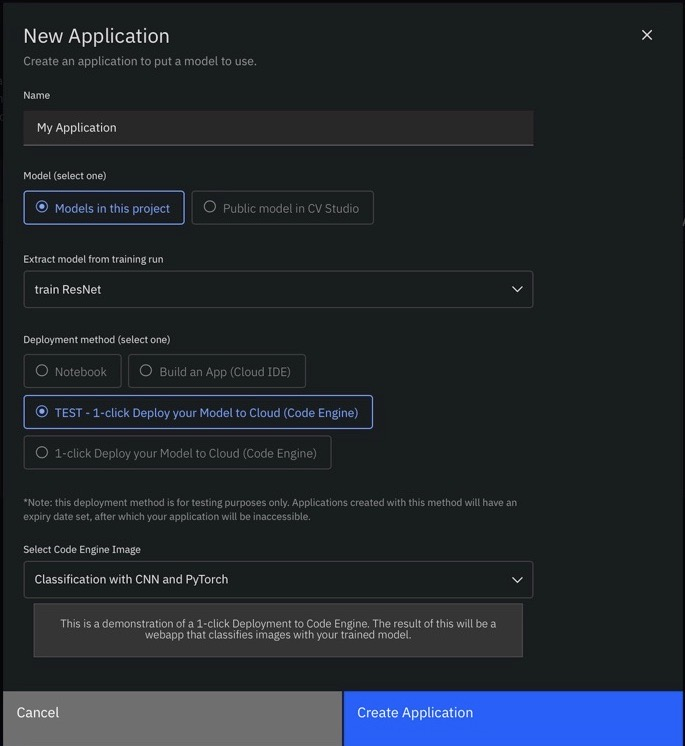

Then once the window is filled out press the Create Application button and your model will begin deploying.

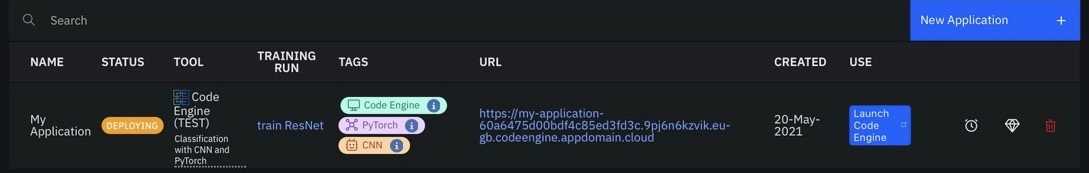]

Wait until the status changes from "deploying" to "ready". Once the status changes to ready, your application is ready for you to use!

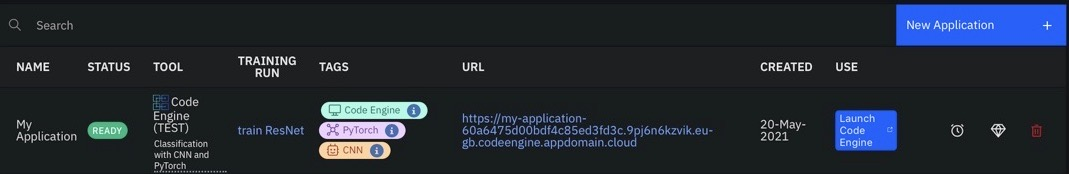

You can press the URL to go to your web application.

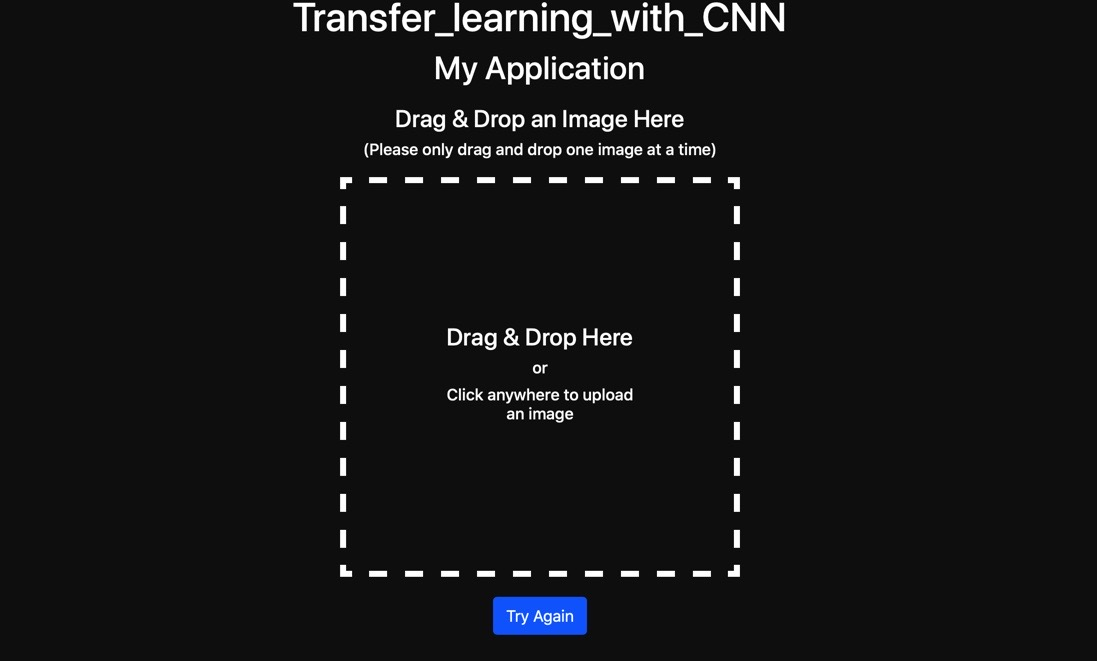

Output: 



![Screenshot (47).png](<attachment:Screenshot (47).png>) ![Screenshot (48).png](<attachment:Screenshot (48).png>)